In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.sparse as sp
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import sys
sys.path.append('../src/')

## Extended survey -> synthetic population

In [2]:
from extended_survey import process_people_df, process_places_df, categorize_p, categorize_v

In [3]:
# Load weights for all TAZ
solutions = []
for fsol_path in Path('./').glob("MUN_*_TAZ_*gsols.pkl"):
    _, mun, _, taz, _ = str(fsol_path).split('_')
    if taz == '-10':
        continue
    df_sol = pd.read_pickle(fsol_path)
    # Best solution, keep only households
    best_sol = df_sol.iloc[0].drop('obj_val').loc[lambda s: s.index > 190000000000]
    # Filter 0 weights
    best_sol = best_sol.loc[lambda s: s > 0]
    best_sol.name = int(taz)
    solutions.append(best_sol)
weights_df = (
    pd.concat(solutions, axis=1)
    .fillna(0).astype(int)
    .sort_index(axis=0).sort_index(axis=1)
)

In [4]:
# Load survey

# Define data paths
personas_path = Path(
    '../data/cuestionario_ampliado/Censo2020_CA_nl_csv/Personas19.CSV'
)
viviendas_path = Path(
    '../data/cuestionario_ampliado/Censo2020_CA_nl_csv/Viviendas19.CSV'
)

# Load survey data
personas = process_people_df(personas_path).set_index(['ID_VIV', 'ID_PERSONA'])
viviendas = process_places_df(viviendas_path).set_index(['ID_VIV'])

# Filter survey to only households in the synthetic pop
viviendas = viviendas.loc[weights_df.index]
personas = personas.loc[weights_df.index]

personas["conact_agg"] = personas.CONACT.map(
    {
        'Trabajó': 'Trabaja',
        'Declara que busca trabajo /  se rescata que trabaja': 'Trabaja',
        'Declara jubilado o pensionado / se rescata que trabaja': 'Trabaja',
        'Declara estudiante / se rescata que trabaja': 'Trabaja',
        'Se dedica a los quehaceres del hogar / se rescata que trabaja': 'Trabaja',
        'Declara que tiene limitaciónes / se rescata que trabaja': 'Trabaja',
        'Declara otra situación de actividad / se rescata que trabaja': 'Trabaja',
        'No se tiene información / se rescata que trabaja': 'Trabaja',
        'Tenía trabajo pero no trabajó': 'Trabaja',
        'Buscó trabajo': 'No trabaja',
        'Es pensionada(o) o jubilada(o)': 'No trabaja',
        'Es estudiante': 'No trabaja',
        'Se dedica a los quehaceres del hogar': 'No trabaja',
        'Está incapacitado permanentemente para trabajar': 'No trabaja',
        'No trabaja': 'No trabaja',
        "Blanco por pase": "Blanco por pase",
    }
)

viviendas["ocupados"] = (
    personas
    .query("EDAD >= 14 & conact_agg == 'Trabaja'")
    .groupby("ID_VIV").size()
    .reindex(viviendas.index)
    .fillna(0)
)


In [5]:
# Build auxiliary columns
def build_var_educa(row):

    nivelaprob = row.NIVACAD
    gradoaprob = row.ESCOLARI
    
    if nivelaprob == "Blanco por pase":
        return "Blanco por pase"

    if nivelaprob == "Ninguno":
        return "Sin instrucción"
    
    if nivelaprob == "Preescolar":
        return "Preescolar"
    
    if (nivelaprob == "Primaria") and  (gradoaprob < 6):
        return "Primaria incompleta"

    if (
        ((nivelaprob == "Primaria") and  (gradoaprob == 6))
        or
        (nivelaprob == "Estudios técnicos o comerciales con primaria terminada")
    ):
        return "Primaria completa"

    if (nivelaprob == "Secundaria") and  (gradoaprob < 3):
        return "Secundaria incompleta"

    if (
        ((nivelaprob == "Secundaria") and  (gradoaprob == 3))
        or
        (nivelaprob == "Estudios técnicos o comerciales con secundaria terminada")
        or
        (nivelaprob == "Normal con primaria o secundaria terminada")
    ):
        return "Secundaria completa"

    if (
        (
            (nivelaprob == "Bachillerato tecnológico")
            or
            (nivelaprob == "Preparatoria o bachillerato general")
        )
        and 
        (gradoaprob < 3)
    ):
        return "Preparatoria incompleta"

    if (
        (
            (
                (nivelaprob == "Bachillerato tecnológico")
                or
                (nivelaprob == "Preparatoria o bachillerato general")
            ) 
            and  
            (gradoaprob >= 3)
        )
        or
        (nivelaprob == "Estudios técnicos o comerciales con preparatoria terminada")
        or
        (nivelaprob == "Normal de licenciatura")
    ):
        return "Preparatoria completa"

    if (nivelaprob == "Licenciatura") and  (gradoaprob < 4):
        return "Profesional incompleta"

    if (
        ((nivelaprob == "Licenciatura") and  (gradoaprob >= 4 ))
    ):
        return "Profesional completa"

    if (
        (nivelaprob == "Maestría")
        or
        (nivelaprob == "Doctorado")
        or
        (nivelaprob == "Especialidad")
    ):
        return "Posgrado"

    assert("Something went wrong")

personas["educa"] = personas.apply(build_var_educa, axis=1)
viviendas["educa_jefe"] = (
    personas
    .query("PARENTESCO == 'Jefa(e)'")[["educa"]]
    .droplevel(1)
)
viviendas["nse_score_educa_jefe"] = viviendas.educa_jefe.map(
    {
        'Sin instrucción': 0,
        'Preescolar': 0,
        'Primaria incompleta': 10,
        'Primaria completa': 22,
        'Secundaria incompleta': 23,
        'Secundaria completa': 31,
        'Preparatoria incompleta': 35,
        'Preparatoria completa': 43,
        'Profesional incompleta': 59,
        'Profesional completa': 73,
        'Posgrado': 101
    }
)

In [6]:
def build_var_bano_comp(row):
    if (
        (row.REGADERA == "Sí")
        and
        (row.SERSAN == "Taza de baño (excusado o sanitario).")
        and
        (row.CONAGUA == "Tiene descarga directa de agua.")
        and
        (row.USOEXC == "No")
    ):
        return "Sí"
    else:
        return "No"

viviendas["bano_comp"] = viviendas.apply(build_var_bano_comp, axis=1)    

In [7]:
viviendas[['educa_jefe', 'bano_comp', 'AUTOPROP', 'INTERNET', 'ocupados', 'CUADORM']]

,educa_jefe,bano_comp,AUTOPROP,INTERNET,ocupados,CUADORM
190010000001,Secundaria completa,Sí,No,No,1.0,1.0
190010000002,Secundaria completa,Sí,No,No,1.0,1.0
190010000003,Secundaria completa,Sí,No,No,1.0,1.0
190010000004,Secundaria incompleta,Sí,No,No,1.0,1.0
190010000006,Profesional incompleta,Sí,Sí,Sí,1.0,2.0
...,...,...,...,...,...,...
190490001400,Secundaria completa,No,Sí,No,1.0,1.0
190490001402,Primaria incompleta,No,Blanco por pase,Blanco por pase,1.0,Blanco por pase
190490001403,Primaria completa,No,Sí,Sí,1.0,2.0
190490001404,Primaria incompleta,No,No,No,2.0,1.0


In [8]:
viviendas.INTERNET.value_counts(dropna=False)

INTERNET
Sí                 40197
No                 17795
Blanco por pase       47
Name: count, dtype: int64

In [9]:
def est_nse(row):
    base_score = 0

    # Educa Jefe Hogar
    base_score += row.nse_score_educa_jefe

    # Internet
    if row.INTERNET == "Sí":
        base_score += 31
    elif row.INTERNET == 'No' or row.INTERNET == 'Blanco por pase':
        pass
    else:
        assert False

    # Ocupados
    x = int(row.ocupados)
    if x == 0:
        pass
    elif x == 1:
        base_score += 15
    elif x == 2:
        base_score += 31
    elif x == 3:
        base_score += 46
    elif x >= 4:
        base_score += 61
    else:
        assert False

    # Cuartos
    x = row.CUADORM
    if x == 'Blanco por pase':
        pass
    elif x == 1:
        base_score += 6
    elif x == 2:
        base_score += 12
    elif x == 3:
        base_score += 17
    elif x >= 4:
        base_score += 23
    else:
        assert False

    # Baño
    x = row.bano_comp
    if x == 'No':
        b1 = b2 = 0
    elif x == 'Sí':
        b1 = 24
        b2 = 47
    else:
        assert False

    # Autos
    x = row.AUTOPROP
    if x == 'No' or x == 'Blanco por pase':
        a1 = a2 = 0
    elif x == 'Sí':
        a1 = 18
        a2 = 37
    else:
        assert False

    score1 = base_score + a1 + b1
    score2 = base_score + a1 + b2
    score3 = base_score + a2 + b1
    score4 = base_score + a2 + b2
    
    return (score1, score2, score3, score4)

In [10]:
viviendas[['nse_score_1', 'nse_score_2', 'nse_score_3', 'nse_score_4']] = viviendas.apply(est_nse, axis=1, result_type='expand')

In [11]:
for ncol in [1, 2, 3, 4]:
    viviendas[f'nse_{ncol}'] = pd.cut(
        viviendas[f'nse_score_{ncol}'],
        bins=[0, 47.5, 89.5, 111.5, 135.5, 165.5, 204.5, 1e6],
        labels=['E', 'D', 'D+', 'C-', 'C', 'C+', 'A/B'],
        right=False
    )

In [12]:
# Transform survey into TSA form
# WARNING: ASSIGN NSE FIRST USING THE ENIGH MODEL BELOW
households = (
    pd.DataFrame(index=viviendas.index)
    .assign(
        #HouseholdId=0,
        #HouseholdZone=0,  # This is TAZ, must replicate for each, remember Alan's map
        #ExpansionFactor=0, # Also unique for each taz,
        NumberOfPersons=viviendas.NUMPERS,
        DwellingType=viviendas.CLAVIVP.map( # 1 is not inner number, 2 inner numb
            {
                'Casa que comparte terreno con otra(s)': 1,
                'Casa única en el terreno': 1,
                'Local no construido para habitación': 2,
                'Vivienda en vecindad o cuartería': 2,
                'Casa dúplex': 1,
                'Refugio': 2,
                'Departamento en edificio': 2,
                'Vivienda móvil': 2,
            }
        ),
        Vehicles=(
            viviendas.AUTOPROP.map(
                {
                    'Sí': 1,
                    'No': 0,
                    'Blanco por pase': 0
                }
            )
            + viviendas.MOTOCICLETA.map(
                {
                    'Sí': 1,
                    'No': 0,
                    'Blanco por pase': 0
                }
            )
        ),  # TODO imputing number of vehicles, this is an at least number
        IncomeClass=viviendas.NSE.map({'E': 1, 'D': 2, 'D+': 3, 'C-': 4, 'C': 4, 'C+': 5, 'A/B': 6, np.nan: 7})
    )
)

AttributeError: 'DataFrame' object has no attribute 'NSE'

In [ ]:
scian_dict_simp =    {
        11: "Agricultura y ganadería", # 1 Agricultura, ganadería, aprovechamiento forestal, pesca y caza
        21: "Minería", # 2 Minería
        22: "Otro", # 3 Generación y distribución de electricidad, suministro de agua y gas
        23: "Construcción", # 4 Construcción
        31: "Industria manufacturera", # 5 Industrias manufactureras
        32: "Industria manufacturera", # 5 Industrias manufactureras
        33: "Industria manufacturera", # 5 Industrias manufactureras
        43: "Comercio", # 6 Comercio al por mayor
        46: "Comercio", # 7 Comercio al por menor
        48: "Transporte y comunicaciones", # 8 Transportes, correos y almacenamiento
        49: "Transporte y comunicaciones", # 8 Transportes, correos y almacenamiento
        51: "Otro", # 9 Información en medios masivos
        52: "Servicios", # 10 Servicios financieros y de seguros
        53: "Servicios", # 11 Servicios inmobiliarios y de alquiler de bienes
        54: "Servicios", # 12 Servicios profesionales, científicos y técnicos
        55: "Servicios", # 13 Corporativos
        56: "Servicios", # 14 Servicios de apoyo a los negocios y manejo de deshechos
        61: "Servicios", # 15 Servicios educativos
        62: "Servicios", # 16 Servicios de salud y de asistencia social
        71: "Servicios", # 17 Servicios de esparcimiento, culturales y deportivos
        72: "Servicios", # 18 Servicios de hospedaje y de preparación de alimentos y bebidas
        81: "Servicios", # 19 Otros servicios, excepto actividades gubernamentales
        93: "Gobierno", # 20 Actividades gubernamentales y de organismos internacionales
        'Blanco por pase': 'Blanco por pase',

    }

In [ ]:
scian_dict = {
        11: 'Agricultura, cría y explotación de animales,'
        ' aprovechamiento forestal, pesca y caza',
        21: 'Minería',
        22: 'Generación, transmisión, distribución y comercialización'
        ' de energía eléctrica, suministro de agua y de gas natural por'
        ' ductos al consumidor final',
        23: 'Construcción',
        31: 'Industrias manufactureras',
        32: 'Industrias manufactureras',
        33: 'Industrias manufactureras',
        43: 'Comercio al por mayor',
        46: 'Comercio al por menor',
        48: 'Transportes, correos y almacenamiento',
        49: 'Transportes, correos y almacenamiento',
        51: 'Información en medios masivos',
        52: 'Servicios financieros y de seguros',
        53: 'Servicios inmobiliarios y de alquiler de bienes muebles'
        ' e intangibles',
        54: 'Servicios profesionales, científicos y técnicos',
        55: 'Corporativos',
        56: 'Servicios de apoyo a los negocios y manejo de residuos,'
        ' y servicios de remediación',
        61: 'Servicios educativos',
        62: 'Servicios de salud y de asistencia social',
        71: 'Servicios de esparcimiento, culturales y deportivos, y'
        ' otros servicios recreativos',
        72: 'Servicios de alojamiento temporal y de preparación de'
        ' alimentos y bebidas',
        81: 'Otros servicios excepto actividades gubernamentales',
        93: 'Actividades legislativas, gubernamentales, de impartición'
        ' de justicia y de organismos internacionales y extraterritoriales',
        # 99: 'Descripciones insuficientemente especificadas general'
        # ' de sector de actividad',
        'Blanco por pase': 'Blanco por pase',
}

In [15]:
scian_dict_inv = {v: k for k, v in scian_dict.items()}

NameError: name 'scian_dict' is not defined

In [13]:
personas.conact_agg.value_counts(dropna=False)

conact_agg
Trabaja            87850
No trabaja         72299
Blanco por pase    42143
Name: count, dtype: int64

In [14]:
people = (
    pd.DataFrame(index=personas.index)
    .assign(
        #HouseholdId=0,
        #PersonNumber=0,
        Age=personas.EDAD,
        Sex=personas.SEXO,
        License=(personas.EDAD >= 18).map({True: 'Y', False: 'N'}),
        TransitPass='N',
        EmploymentStatus=personas.conact_agg.map(
            {
                'Trabaja': 'F', 
                'No trabaja': 'O', 
                'Blanco por pase': 'O',
            }
        ).mask(personas.SERVICIO_MEDICO == 'No', 'P'),
        Occupation=(
            personas.ACTIVIDADES_C
            .map(scian_dict_inv)
            .map(scian_dict_simp)
            .map(
            {
                'Blanco por pase': 'O',
                'Servicios': 'P',
                'Industria manufacturera': 'M',
                'Comercio': 'S',
                'Construcción': 'M',
                'Otro': 'G',
                'Transporte y comunicaciones': 'G',
                'Gobierno': 'G',
                'Agricultura y ganadería': 'G',
                'Minería': 'G',
            }
        )
        ).fillna('G'),
        FreeParking='O',
        StudentStatus=personas.ASISTEN.map({'No': 'O', 'Sí': 'S'}).fillna('O'),
        # EmploymentZone=0,
        # SchoolZone=0,
        # ExpansionFactor=0
    )
)

NameError: name 'scian_dict_inv' is not defined

In [39]:
# Load synthetic weights for every TAZ


In [31]:
households_expanded = (
    weights_df
    .stack()
    .loc[lambda s: s > 0]
    .to_frame()
    .rename(columns={0: 'ExpansionFactor'})
    .rename_axis(index=['ID_VIV', 'HouseholdZone'])
    .reset_index(level=1)
    .pipe(
        lambda df: df.assign(HouseholdId=range(1, len(df)+1))
    )
).join(households, how='left')[
    [
    'HouseholdId', 'HouseholdZone', 'ExpansionFactor', 'NumberOfPersons',
    'DwellingType', 'Vehicles', 'IncomeClass'
    ]
]

In [32]:
households_expanded

,HouseholdId,HouseholdZone,ExpansionFactor,NumberOfPersons,DwellingType,Vehicles,IncomeClass
190010000001,1,391,1,5,1,0,3
190010000002,2,391,1,3,1,0,3
190010000003,3,391,1,3,1,0,3
190010000004,4,391,1,3,1,0,3
190010000006,5,391,1,4,1,1,4
...,...,...,...,...,...,...,...
190490001405,1193322,567,1,3,1,1,4
190490001405,1193323,569,1,3,1,1,4
190490001405,1193324,574,1,3,1,1,4
190490001405,1193325,577,1,3,1,1,4


In [33]:
people_expanded = (
    (
        people
        .assign(
            PersonNumber=(
                people.index.get_level_values(1)
                - people.index.get_level_values(0)*100000
            )
        )
        .droplevel(1)
    )
    .join(households_expanded[['HouseholdId', 'ExpansionFactor']], how='left')
    .sort_values(['HouseholdId', 'PersonNumber'])
)[
    [
        'HouseholdId', 'PersonNumber', 'Age', 'Sex', 'License', 'TransitPass',
        'EmploymentStatus', 'Occupation', 'FreeParking', 'StudentStatus',
        'ExpansionFactor'
    ]
]

In [34]:
people_expanded

,HouseholdId,PersonNumber,Age,Sex,License,TransitPass,EmploymentStatus,Occupation,FreeParking,StudentStatus,ExpansionFactor
ID_VIV,,,,,,,,,,,
190010000001,1,1,9.0,F,N,N,O,O,O,S,1
190010000001,1,2,36.0,M,Y,N,P,M,O,O,1
190010000001,1,3,1.0,M,N,N,O,O,O,O,1
190010000001,1,4,6.0,F,N,N,O,O,O,O,1
190010000001,1,5,30.0,F,Y,N,O,O,O,O,1
...,...,...,...,...,...,...,...,...,...,...,...
190490001405,1193325,2,18.0,F,Y,N,P,S,O,O,1
190490001405,1193325,3,46.0,F,Y,N,O,O,O,O,1
190490001405,1193326,1,50.0,M,Y,N,P,P,O,O,1


In [35]:
households_expanded.to_csv('../output/synth_households_L1.csv', index=False)
people_expanded.to_csv('../output/synth_people_L1.csv', index=False)

Compare with old version, with large households included.

In [44]:
households_expanded_large = pd.read_csv("../output/synth_households_with_large.csv")

In [53]:
households_expanded.groupby("HouseholdZone").ExpansionFactor.sum()

HouseholdZone
1      2403
2      2190
3      1670
4       393
5      4227
       ... 
980     685
981    1339
982      42
983       1
984      18
Name: ExpansionFactor, Length: 714, dtype: int64

In [54]:
households_expanded_large.groupby("HouseholdZone").ExpansionFactor.sum()

HouseholdZone
1      2403
2      2190
3      1670
4       393
5      4227
       ... 
980     685
981    1339
982      42
983       1
984      18
Name: ExpansionFactor, Length: 714, dtype: int64

## NSE

Las columnas necesarias para calcular el nivel socioeconómico de la AMAI son:
- Último año de estudios del jefe del hogar
- Número de baños completos con regadera y W.C.
- Número de automoviles o camionetas
- Internet
- Número de personas mayores de 14 años que trabajan
- Número de cuartos que se usan para dormir

No todas estas variables están disponibles durectamente en el censo. Algunas se pueden calcular y otras se necesitan imputar.

### Último año de estudios del jefe del hogar

|Categoría (2018)       |Categoría (2020)       |Puntaje (2018)| Puentaje (2022)|
|-----------------------|-----------------------|--------------|----------------|
|Sin Instrucción        |                       |            0 |  
|Preescolar             |No estudió             |            0 | 0
|Primaria Incompleta    |Primaria Incompleta    |           10 | 6
|Primaria Completa      |Primaria Completa      |           22 | 11
|Secundaria Incompleta  |Secundaria Incompleta  |           23 | 12
|Secundaria Completa    |Secundaria Completa    |           31 | 18
|                       |Carrera comercial      |              | 23
|                       |Carrera técnica        |              | 23
|Preparatoria Incompleta|Preparatoria Incompleta|           35 | 23
|Preparatoria Completa  |Preparatoria Completa  |           43 | 27
|Licenciatura Incompleta|Licenciatura Incompleta|           59 | 36
|Licenciatura Completa  |Licenciatura Completa  |           73 | 59
|Posgrado               |Diplomado o maestría   |          101 | 85
|                       |Doctorado              |              | 85

La referencia del AMAI para esta variable se basa en la ENIGH y calcula como sigue:

### Número de baños completos con regadera y W.C.

|Categoría (2018)|Categoría (2020)|Puntaje (2018)| Puentaje (2022)|
|----------------|----------------|--------------|----------------|
|0               |0               |            0 |  0
|1               |1               |           24 | 24
|2 ó mas         |2 ó mas         |           47 | 47

### Número de automóviles o camionetas

|Categoría (2018)|Categoría (2020)|Puntaje (2018)| Puentaje (2022)|
|----------------|----------------|--------------|----------------|
|0               |0               |            0 |  0
|1               |1               |           18 | 22
|2 ó mas         |2 ó mas         |           37 | 43

### Internet

|Categoría (2018)|Categoría (2020)|Puntaje (2018)| Puentaje (2022)|
|----------------|----------------|--------------|----------------|
|NO TIENE        |NO TIENE        |            0 |  0
|SÍ TIENE        |SÍ TIENE        |           31 | 32

### Número de personas mayores de 14 años que trabajan

|Categoría (2018)|Categoría (2020)|Puntaje (2018)| Puentaje (2022)|
|----------------|----------------|--------------|----------------|
|0               |0               |            0 |  0
|1               |1               |           15 | 15
|2               |2               |           31 | 31
|3               |3               |           46 | 46
|4 ó mas         |4 ó mas         |           61 | 61

### Número de cuartos que se usan para dormir

|Categoría (2018)|Categoría (2020)|Puntaje (2018)| Puentaje (2022)|
|----------------|----------------|--------------|----------------|
|0               |0               |            0 |  0
|1               |1               |            6 |  8
|2               |2               |           12 | 16
|3               |3               |           17 | 24
|4 ó mas         |4 ó mas         |           23 | 32

### Clasificación NSE

|Nivel Socioecónomico|Puntos 2018|Puntos 2020|
|--------------------|-----------|-----------|
| A/B                | 205 - inf | 202 - inf
| C+                 | 166 - 204 | 168 - 201
| C                  | 136 - 165 | 141 - 167
| C-                 | 112 - 135 | 116 - 140
| D+                 |  90 - 111 |  95 - 115
| D                  |  48 - 89  |  48 - 94
| E                  |   0 - 47  |   0 - 47

Variables auxiliares para imputar NSE disponibles en el censo y la ENIGH:
- Ingreso mensual por trabajo del hogar.

## ENIGH

In [16]:
# Load ENIGH
enigh_dir = Path('../data/ENIGH/2018')
enigh_viviendas = pd.read_csv(enigh_dir / 'viviendas.csv', low_memory=False)
enigh_hogares = pd.read_csv(enigh_dir / 'hogares.csv', low_memory=False)
enigh_concentrado = pd.read_csv(enigh_dir / 'concentradohogar.csv', low_memory=False)

# Merging into single database
enigh_viv_hog = (
    enigh_hogares
    .merge(enigh_concentrado, on=['folioviv', 'foliohog'])
    .merge(enigh_viviendas, on='folioviv')
).set_index(['folioviv', 'foliohog'])

# Building variables for NSE
enigh_viv_hog['autos'] = (
    enigh_viv_hog.num_auto
    + enigh_viv_hog.num_van
    + enigh_viv_hog.num_pickup
)

enigh_viv_hog['conex_inte'] = enigh_viv_hog.conex_inte.map({1: 'Sí', 2: 'No'})

enigh_viv_hog['educa_jefe'] = enigh_viv_hog['educa_jefe'].map(
    {
        1: 'Sin instrucción',
        2: 'Preescolar',
        3: 'Primaria incompleta',
        4: 'Primaria completa',
        5: 'Secundaria incompleta',
        6: 'Secundaria completa',
        7: 'Preparatoria incompleta',
        8: 'Preparatoria completa',
        9: 'Profesional incompleta',
        10: 'Profesional completa',
        11: 'Posgrado',
    }
)

enigh_viv_hog['bano_comp'] = enigh_viv_hog.bano_comp.replace(' ', np.nan).astype(float)

In [17]:
def score_bano(x):
    if np.isnan(x):
        return x
    x = int(x)
    if x == 0:
        return 0
    elif x == 1:
        return 24
    else:
        return 47


def score_autos(x):
    if np.isnan(x):
        return x
    x = int(x)
    if x == 0:
        return 0
    elif x == 1:
        return 18
    else:
        return 37

def score_ocupados(x):
    if np.isnan(x):
        return x
    x = int(x)
    if x == 0:
        return 0
    elif x == 1:
        return 15
    elif x == 2:
        return 31
    elif x == 3:
        return 46
    else:
        return 61

def score_cuartos(x):
    if np.isnan(x):
        return x
    x = int(x)
    if x == 0:
        return 0
    elif x == 1:
        return 6
    elif x == 2:
        return 12
    elif x == 3:
        return 17
    else:
        return 23

In [18]:
# Scoring education
enigh_viv_hog["nse_score_education"] = enigh_viv_hog.educa_jefe.map(
    {
        'Sin instrucción': 0,
        'Preescolar': 0,
        'Primaria incompleta': 10,
        'Primaria completa': 22,
        'Secundaria incompleta': 23,
        'Secundaria completa': 31,
        'Preparatoria incompleta': 35,
        'Preparatoria completa': 43,
        'Profesional incompleta': 59,
        'Profesional completa': 73,
        'Posgrado': 101
    }
)

enigh_viv_hog["nse_score_bathrooms"] = enigh_viv_hog.bano_comp.apply(score_bano)

enigh_viv_hog["nse_score_autos"] = enigh_viv_hog.autos.apply(score_autos)

enigh_viv_hog["nse_score_internet"] = enigh_viv_hog.conex_inte.map(
    {
        'No': 0,
        'Sí': 31
    }
)

enigh_viv_hog["nse_score_ocupados"] = enigh_viv_hog.ocupados.apply(score_ocupados)

enigh_viv_hog["nse_score_cuartos"] = enigh_viv_hog.ocupados.apply(score_cuartos)

enigh_viv_hog["nse_score"] = enigh_viv_hog[
    [c for c in enigh_viv_hog.columns if c.startswith('nse_score_')]
].sum(axis=1, skipna=False)

enigh_viv_hog["nse"] = pd.cut(
    enigh_viv_hog.nse_score,
    bins=[0, 47.5, 89.5, 111.5, 135.5, 165.5, 204.5, 1e6],
    labels=['E', 'D', 'D+', 'C-', 'C', 'C+', 'A/B'],
    right=False
)

In [19]:
import seaborn as sns

In [20]:
enigh_viv_hog['log_ingtrab'] = np.log(enigh_viv_hog.ingtrab)
enigh_viv_hog['log_ingcor'] = np.log(enigh_viv_hog.ing_cor)

/Users/gperaza/Drive/Research/population-synthesis/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gperaza/Drive/Research/population-synthesis/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


We will now create a mixture model for NSE from the ENIGH data base an use such model to assign NSE in the Cennsus from the restricted list of possible values.
We'll work with the logarithm of income.

In [21]:
nse_train = enigh_viv_hog[["ing_cor", "ingtrab", "nse", "ocupados", "perc_ocupa"]]
p_nse = nse_train.groupby('nse', observed=True).size()/nse_train.shape[0]

In [22]:
# When working with log(income) we must explore 0 income values by themselves
# 0 income, or missing income, may refer to a houshold with retired inhabitants 
# or people with a different source of income, such as rents.
# Ideally we should be able to distinguish both cases
p_nse_0_ingtrab = nse_train.query("ingtrab == 0").pipe(
    lambda df: df.groupby('nse', observed=True).size()/df.shape[0]
)
p_nse_pos_ingtrab = nse_train.query("ingtrab > 0").pipe(
    lambda df: df.groupby('nse', observed=True).size()/df.shape[0]
)

In [23]:
from scipy import stats

In [24]:
# for each NSE category, otbain empirical model
ecdf_dict = {}
kpdf_dict = {}
for nse, ingtrab in nse_train.query("ingtrab > 0").groupby('nse', observed=True).ingtrab:
    log_ingtrab = np.log(ingtrab)
    ecdf_dict[nse] = stats.ecdf(log_ingtrab)
    kpdf_dict[nse] = stats.gaussian_kde(log_ingtrab)

In [25]:
def p_ingtrab(x, kpdf_dict, p_nse_s):
    """ Mixture model for ingtran.
    This is just the normalization constant of the bayes theorem. """

    p = 0
    for nse, p_nse in p_nse_s.items():
        p += p_nse*kpdf_dict[nse].pdf(x)
    return p

def p_nse_given_ingtrab(row, kpdf_dict, p_nse_pos, p_nse_0):
    """Finds p(nse|ingtrab) = p(ing|nse)p(nse)/p(ingtrab)
    We avoid calculating p(ingtrab) by just normalizing the probabilities.

    We only consider the possible NSE classes.
    """

    # Make ing trimestral
    ingtrab = row.INGTRHOG*3
    nse_list = row[['nse_1', 'nse_2', 'nse_3', 'nse_4']].unique()

    p_list = np.zeros(7)
    
    for i, (nse, p_nse) in enumerate(p_nse_0.items()):
        if ingtrab == 0:
            p = p_nse_0[nse]
        else:
            p = kpdf_dict[nse].pdf(np.log(ingtrab))#*p_nse_pos[nse]
            p = p[0]
        p = p*(nse in nse_list)
        p_list[i] = p

    p_list = p_list / p_list.sum()
    return p_nse_pos.index[np.argmax(p_list)]

In [26]:
%%timeit
p_nse_given_ingtrab(viviendas.loc[190010000393], kpdf_dict, p_nse_pos_ingtrab, p_nse_0_ingtrab)

KeyError: 190010000393

In [ ]:
%%time
viviendas['INGTRHOG'] = viviendas['INGTRHOG'].replace('Blanco por pase', '0').astype(float)
viviendas['NSE'] = viviendas.apply(
    p_nse_given_ingtrab,
    axis=1,
    args=(kpdf_dict, p_nse_pos_ingtrab, p_nse_0_ingtrab)
)

In [864]:
viviendas.NSE.value_counts().sort_index()/len(viviendas)

NSE
A/B    0.108719
C      0.227724
C+     0.186224
C-     0.195620
D      0.125174
D+     0.132184
E      0.024356
Name: count, dtype: float64

In [32]:
viviendas.NSE.value_counts().sort_index()/len(viviendas)

NSE
A/B    0.108724
C      0.227520
C+     0.186336
C-     0.195765
D      0.124958
D+     0.132304
E      0.024392
Name: count, dtype: float64

In [ ]:
enigh_concentrado.geo

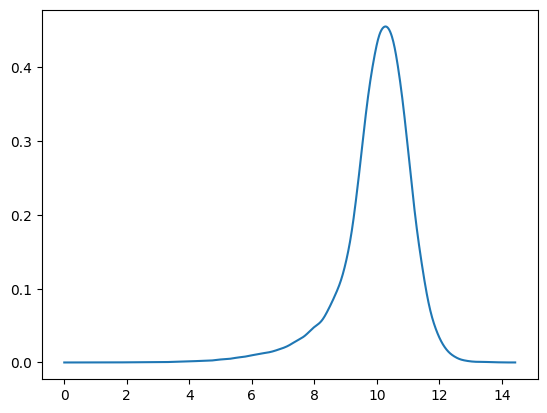

In [651]:
xgrid = np.log(np.geomspace(1, nse_train.ingtrab.max(), 1000))
plt.plot(
    xgrid,
    [p_ingtrab(x, kpdf_dict, p_nse_pos_ingtrab) for x in xgrid]
)

In [649]:
np.log(nse_train.ingtrab.max())

14.425921850410422

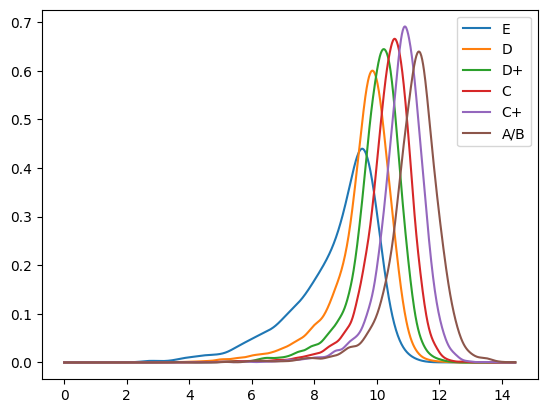

In [653]:
xgrid = np.log(np.geomspace(1, nse_train.ingtrab.max(), 1000))
for nse, kernel in kpdf_dict.items():
    plt.plot(
        xgrid,
        kernel(xgrid),
        label=nse
    )
plt.legend()

<Axes: xlabel='log_ingtrab', ylabel='Density'>

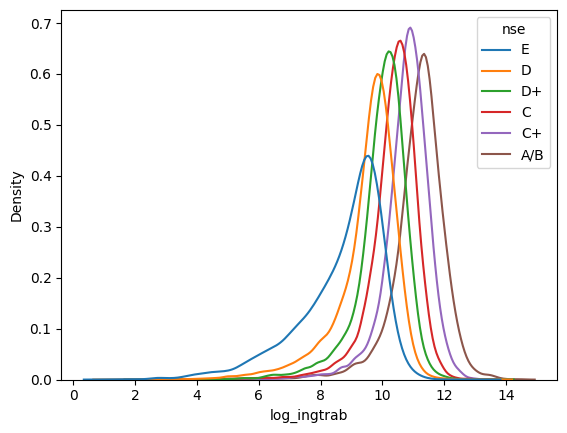

In [655]:
sns.kdeplot(enigh_viv_hog, x='log_ingtrab', hue='nse', common_norm=False)

In [659]:
p_nse_given_ingtrab

<function __main__.p_nse_given_ingtrab(ingtrab, ecdf_dict, p_nse)>

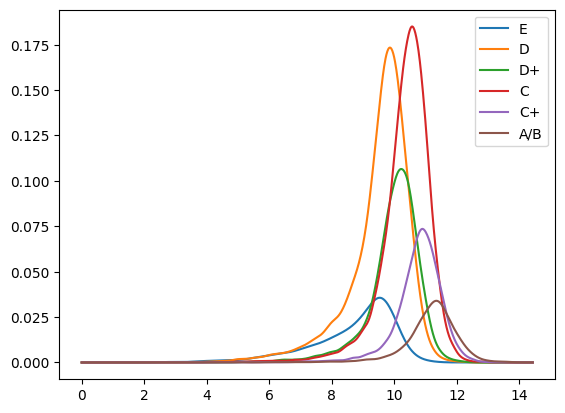

In [660]:
xgrid = np.log(np.geomspace(1, nse_train.ingtrab.max(), 1000))
for nse, kernel in kpdf_dict.items():
    plt.plot(
        xgrid,
        kernel(xgrid)*p_nse_pos_ingtrab[nse],
        label=nse
    )
plt.legend()

<Axes: xlabel='log_ingtrab', ylabel='Density'>

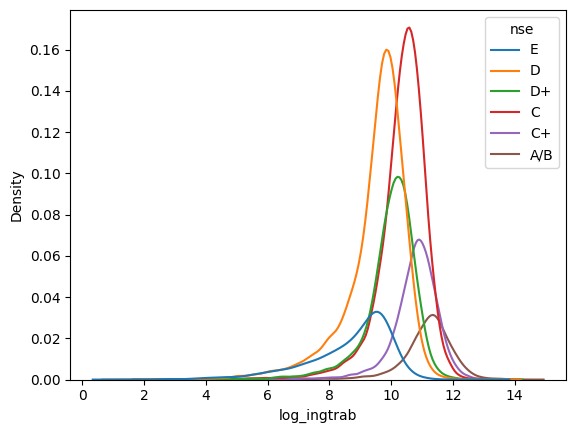

In [656]:
sns.kdeplot(enigh_viv_hog, x='log_ingtrab', hue='nse', common_norm=True)